# Simplify core!

In [1]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [2]:
from phydra.processes.variables import StateVariable
from phydra.processes.fluxes import LinearOutputFlux, LinearInputFlux

In [3]:
import numpy as np

In [4]:
TestModel = phydra.create({'S':StateVariable, 'X':StateVariable,
                          'Input1':LinearInputFlux, 'Output1':LinearOutputFlux})

In [5]:
TestModel

<xsimlab.Model (7 processes, 8 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) sequence of time points fo...
S
    init            [in]
X
    init            [in]
Input1
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
Output1
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
Solver

In [6]:
odeint_setup = phydra.setup('odeint', TestModel,
            time=np.arange(0,20,0.1),
            input_vars={
                'S__init':0.5,
                'X__init':0.7,
                'Input1':{'sv':'S','rate':0.1},
                'Output1':{'sv':'X','rate':0.1},
            },
            output_vars={'S__value', 'X__value'}
            )

In [7]:
with TestModel:
    odeint_out = odeint_setup.xsimlab.run()

initializing model core
Initializing Model Time
calling model context
initializing state variable S
calling model context
initializing state variable X
initializing flux Input1
initializing flux Output1
assembling model
SOLVER : <phydra.core.solvers.ODEINTSolver object at 0x16104c730>
start solve now
finalizing: cleanup
Model was solved in 0.00322 seconds
Cleanup method is called within Model class


In [8]:
odeint_out

<xarray.Dataset>
Dimensions:            (clock: 2, input_time: 200, time: 200)
Coordinates:
  * clock              (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type  <U6 'odeint'
    Input1__rate       float64 0.1
    Input1__sv         <U1 'S'
    Output1__rate      float64 0.1
    Output1__sv        <U1 'X'
    S__init            float64 0.5
    S__value           (time) float64 0.5 0.505 0.5101 ... 3.585 3.621 3.658
    Time__time         (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    X__init            float64 0.7
    X__value           (time) float64 0.7 0.693 0.6861 ... 0.09665 0.09569

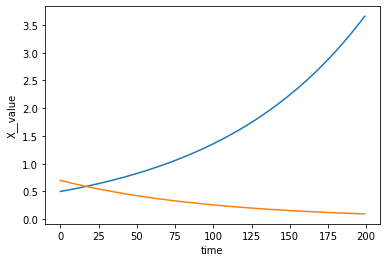

In [9]:
odeint_out.S__value.plot()
odeint_out.X__value.plot()

In [10]:
stepwise_setup = phydra.update_setup(model=TestModel, old_setup=odeint_setup, new_solver="stepwise")

In [11]:
with TestModel:
    stepwise_out = stepwise_setup.xsimlab.run()

initializing model core
Initializing Model Time
calling model context
initializing state variable S
calling model context
initializing state variable X
initializing flux Input1
initializing flux Output1
assembling model
SOLVER : <phydra.core.solvers.StepwiseSolver object at 0x1621a99a0>
finalizing: cleanup
Model was solved in 0.10393 seconds
Cleanup method is called within Model class


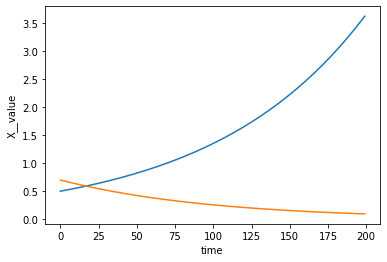

In [12]:
stepwise_out.S__value.plot()
stepwise_out.X__value.plot()

In [13]:
gekko_setup = phydra.update_setup(model=TestModel, old_setup=odeint_setup, new_solver="gekko")

In [14]:
with TestModel:
    gekko_out = gekko_setup.xsimlab.run()

initializing model core
Initializing Model Time
calling model context
initializing state variable S
calling model context
initializing state variable X
initializing flux Input1
initializing flux Output1
assembling model
SOLVER : <phydra.core.solvers.GEKKOSolver object at 0x16211e8b0>
time 1
s (0+((s)*(0.1)))
x (0+(-((x)*(0.1))))
['$time=1', '$s=(0+((s)*(0.1)))', '$x=(0+(-((x)*(0.1))))']
finalizing: cleanup
Model was solved in 0.12817 seconds
Cleanup method is called within Model class


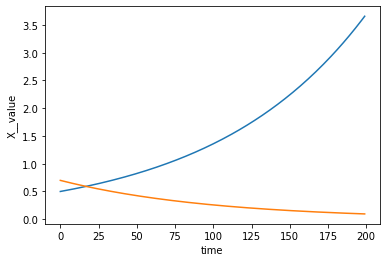

In [15]:
gekko_out.S__value.plot()
gekko_out.X__value.plot()

In [ ]:
# SO what i need to do is
a) add the variable to the model backend
b) store the value of this variable within xarray process "value"

# What can the xarray process contain?
pretty much anything that the user wants.. but essential contents are an initial value and the store for the output

# for arrays of variables, these can be similarly stored in a different subprocess, that does all the work of

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# to measure process time
import time as tm

In [3]:
from xsimlab.monitoring import ProgressBar

In [4]:
from phydra.processes.statevars import SV, Time

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing

from phydra.processes.fluxes import (LinearOutputFlux, ForcingLinearInputFlux, 
                                     MonodUptake, HollingTypeIIIGrazing,
                                    
                                    MultiLossTest, PartialOutputLossTest)

In [5]:
# use function instead! ecological processes
@phydra.flux
class HollingTypeIIIGrazing:
    resource = phydra.sv(flow='output')
    consumer = phydra.sv(flow='input')
    feed_pref = phydra.param(description='feeding preferences')
    Imax = phydra.param(description='maximum ingestion rate')
    kZ = phydra.param(description='feeding preferences')

    def flux(resource, consumer, feed_pref, Imax, kZ):
        return Imax * resource ** 2 \
               * feed_pref / (kZ ** 2 + sum([resource ** 2 * feed_pref])) * consumer

In [6]:
NPZD = phydra.create({
    # SV
    'N':SV,
    'P':SV,
    'Z':SV,
    'D':SV,
    
    # Fluxes
    'N_loss':LinearOutputFlux,
    'P_loss':LinearOutputFlux,
    
    # Exchanges
    'Monod':MonodUptake,
    'Grazing':HollingTypeIIIGrazing,
    
    # Forcing
    'N_input':ForcingLinearInputFlux,
    'N0':ConstantForcing
})

In [7]:
NPZD

<xsimlab.Model (13 processes, 22 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
N
    init            [in]
P
    init            [in]
Z
    init            [in]
D
    init            [in]
N0
    value           [in]
N_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
P_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
Monod
    halfsat         [in] half saturation constant
    resource        [in]
    consumer        [in]
Grazing
    feed_pref       [in] feeding preferences
    consumer        [in]
    kZ              [in] feeding preferences
    resource        [in]
    Imax            [in] maximum ingestion rate
N_input
    sv              [in] state variable affected by forcing flux
    rate            [in] flowing rate
    fx              [in] forcing affecting rate
Solver

In [8]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,20,0.1),
            input_vars={
                'N__init':0.5,
                'P__init':0.5,
                'Z__init':0.5,
                'D__init':0.5,
                
                'N_loss':{'sv':'N',
                          'rate':.01},
                
                'P_loss':{'sv':'P',
                          'rate':.5},
                
                'N_input':{'sv':'N',
                          'fx':'N0',
                          'rate':.1},
                
                'Monod':{'resource':'N',
                        'consumer':'P',
                        'halfsat':.5},
                
                'Grazing':{'resource':'P',
                        'consumer':'Z',
                        'feed_pref':1.,
                        'Imax':1.5,
                        'kZ':.7},
                
                'N0__value':2.,
            },
            output_vars={'N__value','P__value','Z__value','D__value'}
            )

In [9]:
gekko_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="gekko")

In [10]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [11]:
odeint_setup

<xarray.Dataset>
Dimensions:             (clock: 2, input_time: 200)
Coordinates:
  * clock               (clock) int64 0 1
Dimensions without coordinates: input_time
Data variables:
    N__init             float64 0.5
    P__init             float64 0.5
    Z__init             float64 0.5
    D__init             float64 0.5
    N_loss__sv          <U1 'N'
    N_loss__rate        float64 0.01
    P_loss__sv          <U1 'P'
    P_loss__rate        float64 0.5
    N_input__sv         <U1 'N'
    N_input__fx         <U2 'N0'
    N_input__rate       float64 0.1
    Monod__resource     <U1 'N'
    Monod__consumer     <U1 'P'
    Monod__halfsat      float64 0.5
    Grazing__resource   <U1 'P'
    Grazing__consumer   <U1 'Z'
    Grazing__feed_pref  float64 1.0
    Grazing__Imax       float64 1.5
    Grazing__kZ         float64 0.7
    N0__value           float64 2.0
    Core__solver_type   <U6 'odeint'
    Time__time          (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
Attributes:
    __xsimlab_output_vars__:  Z__value,N__value,P__value,D__value

and solve the model like this:

In [12]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=NPZD)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Z
calling model context
initializing state variable D
calling model context
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux Grazing
initializing flux N_input
assembling model
SOLVER : odeint
start solve now
Model was solved in 0.00516 seconds
here unpacking values time
here unpacking values N
here unpacking values P
here unpacking values Z
here unpacking values D
finalizing: cleanup


In [13]:
out_ds

<xarray.Dataset>
Dimensions:             (clock: 2, input_time: 200, time: 200)
Coordinates:
  * clock               (clock) int64 0 1
Dimensions without coordinates: input_time, time
Data variables:
    Core__solver_type   <U6 'odeint'
    D__init             float64 0.5
    D__value            (time) float64 0.5 0.5 0.5 0.5 0.5 ... 0.5 0.5 0.5 0.5
    Grazing__Imax       float64 1.5
    Grazing__consumer   <U1 'Z'
    Grazing__feed_pref  float64 1.0
    Grazing__kZ         float64 0.7
    Grazing__resource   <U1 'P'
    Monod__consumer     <U1 'P'
    Monod__halfsat      float64 0.5
    Monod__resource     <U1 'N'
    N0__value           float64 2.0
    N__init             float64 0.5
    N__value            (time) float64 0.5 0.4952 0.4917 ... 2.653 2.663 2.673
    N_input__fx         <U2 'N0'
    N_input__rate       float64 0.1
    N_input__sv         <U1 'N'
    N_loss__rate        float64 0.01
    N_loss__sv          <U1 'N'
    P__init             float64 0.5
    P__value            (time) float64 0.5 0.4748 0.4502 ... 0.08822 0.08821
    P_loss__rate        float64 0.5
    P_loss__sv          <U1 'P'
    Time__time          (input_time) float64 0.0 0.1 0.2 0.3 ... 19.7 19.8 19.9
    Z__init             float64 0.5
    Z__value            (time) float64 0.5 0.5251 0.5496 ... 1.288 1.291 1.294

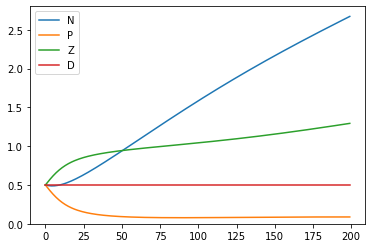

In [14]:
plt.plot(out_ds.N__value, label='N')
plt.plot(out_ds.P__value, label='P')
plt.plot(out_ds.Z__value, label='Z')
plt.plot(out_ds.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [15]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=NPZD)

             0% | initialize 

initializing model core
Initializing Model Time
creating new SV StateVariable(name='time', initial_value=0.0, value=None, lb=0)
calling model context
initializing state variable N
creating new SV StateVariable(name='N', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable P
creating new SV StateVariable(name='P', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable Z
creating new SV StateVariable(name='Z', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable D
creating new SV StateVariable(name='D', initial_value=0.5, value=None, lb=0)
calling model context
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux Grazing
initializing flux N_input
assembling model
SOLVER : gekko
time 1
n (((0+(-((n)*(0.01))))+(-((((n)/((n+0.5))))*(p))))+0.2)
p (((0+(-((p)*(0.5))))+((((n)/((n+0.5))))*(p)))+(-((((((((1.5)*(((p)^(2)))))*(1.0)))/((0

██████████ 100% | Simulation finished in 00:00 

Model was solved in 0.29 seconds
finalizing: cleanup


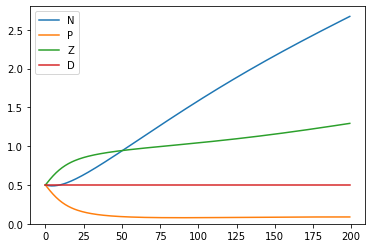

In [16]:
plt.plot(out_ds1.N__value, label='N')
plt.plot(out_ds1.P__value, label='P')
plt.plot(out_ds1.Z__value, label='Z')
plt.plot(out_ds1.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [17]:
with ProgressBar(frontend="console"):
    out_ds2 = stepwise_setup.xsimlab.run(model=NPZD)

██████▋     67% | run step 133/199 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Z
calling model context
initializing state variable D
calling model context
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux Grazing
initializing flux N_input
assembling model
SOLVER : stepwise


██████████ 100% | Simulation finished in 00:00 

finalizing: cleanup


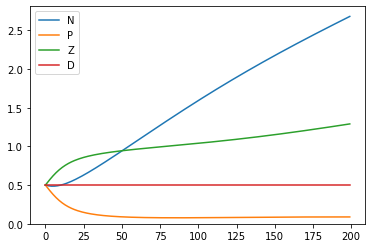

In [18]:
plt.plot(out_ds2.N__value, label='N')
plt.plot(out_ds2.P__value, label='P')
plt.plot(out_ds2.Z__value, label='Z')
plt.plot(out_ds2.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [15]:
MultiTest = phydra.create({
    # SV
    'N':SV,
    'P':SV,
    'Q':SV,
    
    # Fluxes
    'Loss':LinearOutputFlux,
    'MultiLoss':MultiLossTest,
    
    # Forcing
    'N_input':ForcingLinearInputFlux,
    'N0':ConstantForcing, #SinusoidalForcing
})

In [16]:
MultiTest

<xsimlab.Model (10 processes, 14 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
N
    init            [in]
P
    init            [in]
Q
    init            [in]
N0
    value           [in]
Loss
    rate            [in] flowing rate
    sv              [in] state variable affected by flux
MultiLoss
    sink            [in]
    rate            [in] () or ('MultiLoss',) 
    sources         [in] ('MultiLoss',) 
N_input
    fx              [in] forcing affecting rate
    sv              [in] state variable affected by forcing flux
    rate            [in] flowing rate
Solver

In [17]:
odeint_setup = phydra.setup('odeint', MultiTest,
            time=np.arange(0,20,0.01),
            input_vars={
                'N__init':0.5,
                'P__init':0.5,
                'Q__init':0.7,
                
                'Loss':{'sv':'N',
                          'rate':.01},
                
                'MultiLoss':{'sources':['N','P'],
                             'sink':'Q',
                            'rate':[.2,.1]},
                
                'N_input':{'fx':'N0',
                          'rate':0.5,
                          'sv':'N'},
                
                'N0':{'value':2},
                
            },
            output_vars={'N__value','P__value','Q__value'}
            )

In [18]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=MultiTest)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Q
calling model context
initializing forcing N0
initializing flux Loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_name': 'sink', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.INPUT: 'input'>, 'dims': [()], 'partial_out': 'sink_out', 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': [()]}], <FluxVarType.PARAMETER: 'parameter'>: [{'var_na

In [19]:
out_ds

<xarray.Dataset>
Dimensions:             (MultiLoss: 2, clock: 2, input_time: 2000, time: 2000)
Coordinates:
  * clock               (clock) int64 0 1
Dimensions without coordinates: MultiLoss, input_time, time
Data variables:
    Core__solver_type   <U6 'odeint'
    Loss__rate          float64 0.01
    Loss__sv            <U1 'N'
    MultiLoss__rate     (MultiLoss) float64 0.2 0.1
    MultiLoss__sink     <U1 'Q'
    MultiLoss__sources  (MultiLoss) <U1 'N' 'P'
    N0__value           int64 2
    N__init             float64 0.5
    N__value            (time) float64 0.5 0.5089 0.5179 ... 4.698 4.698 4.698
    N_input__fx         <U2 'N0'
    N_input__rate       float64 0.5
    N_input__sv         <U1 'N'
    P__init             float64 0.5
    P__value            (time) float64 0.5 0.4995 0.499 ... 0.0678 0.06774
    Q__init             float64 0.7
    Q__value            (time) float64 0.7 0.7015 0.703 ... 16.15 16.16 16.17
    Time__time          (input_time) float64 0.0 0.01 0.02 ... 19.97 19.98 19.99

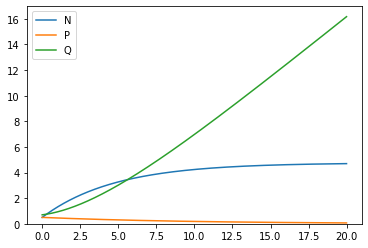

In [20]:
plt.plot(out_ds.Time__time, out_ds.N__value, label='N')
plt.plot(out_ds.Time__time, out_ds.P__value, label='P')
plt.plot(out_ds.Time__time, out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [21]:
gekko_setup = phydra.update_setup(model=MultiTest, old_setup=odeint_setup, new_solver="gekko")

In [22]:
stepwise_setup = phydra.update_setup(model=MultiTest, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [23]:
# stepwise_setup

and solve the model like this:

In [24]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=MultiTest)

██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Q
calling model context
initializing forcing N0
initializing flux Loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_name': 'sink', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.INPUT: 'input'>, 'dims': [()], 'partial_out': 'sink_out', 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': [()]}], <FluxVarType.PARAMETER: 'parameter'>: [{'var_na

In [25]:
# out_ds

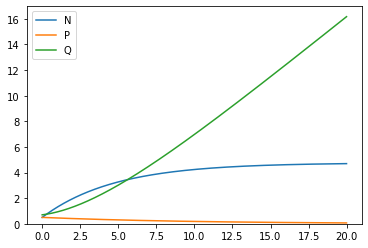

In [26]:
plt.plot(out_ds.Time__time, out_ds.N__value, label='N')
plt.plot(out_ds.Time__time, out_ds.P__value, label='P')
plt.plot(out_ds.Time__time, out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [27]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=MultiTest)

             0% | initialize 

initializing model core
Initializing Model Time
creating new SV StateVariable(name='time', initial_value=0.0, value=None, lb=0)
calling model context
initializing state variable N
creating new SV StateVariable(name='N', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable P
creating new SV StateVariable(name='P', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable Q
creating new SV StateVariable(name='Q', initial_value=0.7, value=None, lb=0)
calling model context
initializing forcing N0
initializing flux Loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_name'

██████████ 100% | Simulation finished in 00:05 

Model was solved in 5.45 seconds
finalizing: cleanup


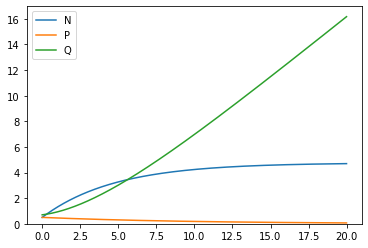

In [28]:
plt.plot(out_ds.Time__time, out_ds.N__value, label='N')
plt.plot(out_ds.Time__time, out_ds.P__value, label='P')
plt.plot(out_ds.Time__time, out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [29]:
with ProgressBar(frontend="console"):
    out_ds2 = stepwise_setup.xsimlab.run(model=MultiTest)

▋            7% | run step 137/1999 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Q
calling model context
initializing forcing N0
initializing flux Loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_name': 'sink', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.INPUT: 'input'>, 'dims': [()], 'partial_out': 'sink_out', 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': [()]}], <FluxVarType.PARAMETER: 'parameter'>: [{'var_na

██████████ 100% | Simulation finished in 00:02 


finalizing: cleanup


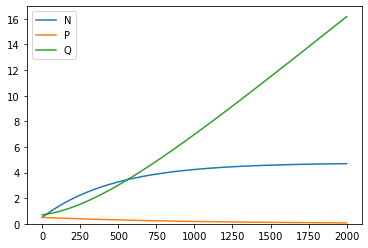

In [30]:
plt.plot(out_ds2.N__value, label='N')
plt.plot(out_ds2.P__value, label='P')
plt.plot(out_ds2.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
NPZD = phydra.create({
    # SV
    'N':SV,
    'P':SV,
    'Z':SV,
    'D':SV,
    
    # Fluxes
    'N_loss':LinearOutputFlux,
    'P_loss':LinearOutputFlux,
    
    # Exchanges
    'Monod':MonodUptake,
    'Grazing':HollingTypeIIIGrazing,
    
    # Forcing
    'N_input':ForcingLinearInputFlux,
    'N0':ConstantForcing
})

In [ ]:
NPZD

In [ ]:
#Model.visualize(show_inputs=True)

In [ ]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,20,0.1),
            input_vars={
                'N__init':0.5,
                'P__init':0.5,
                'Z__init':0.5,
                'D__init':0.5,
                
                'N_loss':{'sv':'N',
                          'rate':.01},
                
                'P_loss':{'sv':'P',
                          'rate':.5},
                
                'N_input':{'sv':'N',
                          'fx':'N0',
                          'rate':.1},
                
                'Monod':{'resource':'N',
                        'consumer':'P',
                        'halfsat':.5},
                
                'Grazing':{'resource':'P',
                        'consumer':'Z',
                        'feed_pref':1.,
                        'Imax':1.5,
                        'kZ':.7},
                
                'N0__value':2.,
            },
            output_vars={'N__value','P__value','Z__value','D__value'}
            )

In [ ]:
gekko_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="gekko")

In [ ]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [ ]:
# stepwise_setup

and solve the model like this:

In [ ]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=NPZD)

In [ ]:
# out_ds

In [ ]:
plt.plot(out_ds.N__value, label='N')
plt.plot(out_ds.P__value, label='P')
plt.plot(out_ds.Z__value, label='Z')
plt.plot(out_ds.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=NPZD)

In [ ]:
plt.plot(out_ds1.N__value, label='N')
plt.plot(out_ds1.P__value, label='P')
plt.plot(out_ds1.Z__value, label='Z')
plt.plot(out_ds1.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
with ProgressBar(frontend="console"):
    out_ds2 = stepwise_setup.xsimlab.run(model=NPZD)

In [ ]:
plt.plot(out_ds2.N__value, label='N')
plt.plot(out_ds2.P__value, label='P')
plt.plot(out_ds2.Z__value, label='Z')
plt.plot(out_ds2.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()